# Example: Bayesian estimation with structured latent confounders

In [1]:
from typing import Dict, List, Optional, Tuple, Union, TypeVar

import torch
import pyro
import torch.nn as nn
import pyro.distributions as dist
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from torch import Tensor
from torch.nn import functional as F

from pyro.nn import PyroModule, PyroSample
from pyro.poutine import condition, replay, trace

from pyro.infer.autoguide.guides import AutoDelta,  AutoNormal
from pyro.infer.autoguide.structured import AutoStructured
from pyro.infer import SVI, Trace_ELBO, Predictive

import causal_pyro
from causal_pyro.query.do_messenger import do
from causal_pyro.counterfactual.handlers import MultiWorldCounterfactual

## Background: Hierarchically structured confounding

In other examples, we have demonstrated how probabilistic
programs can be used to model causal relationships between attributes of
individual entities. However, it is often useful to model relationships
between multiple kinds of entities explicitly.

For example, a student's
educational outcome may depend on her own attributes, as well as the
attributes of her school. In this hierarchical setting, where multiple
students belong to the same school, we can often estimate causal effects
even if these potentially confounding school-level attributes are
latent.

Hierarchical structure is a common motif in social science and
econometric applications of causal inference; appearing in
multi-level-models [@gelman2006data], difference-in-difference
designs [@shadish2002experimental], and within-subjects
designs [@loftus1994using], all of which are out of scope for
graph-based identification methods. Nonetheless, even flexible Gaussian
process versions of these kinds of causal designs can be implemented in
a causal probabilistic programming language [@witty_2021]. 

## Example: Sesame Data

In [2]:
DATA_URL = "https://raw.githubusercontent.com/avehtari/ROS-Examples/master/ElectricCompany/data/electric.csv"

df = pd.read_csv(DATA_URL, delimiter=",", index_col=0)

# See Chapter 23 in http://ecologia.ib.usp.br/curso_r/lib/exe/fetch.php/bie5782:00_curso_avancado:uriarte:gelman_hill2007_data_analysis_using_regression_and_multilevel-hierarchical_models.pdf

# They drop the description of whether the intervention was used as a supplement to teaching or as a replacement for teaching, as it is post-treatment and
# may introduce collider bias.
df = df.drop("supp", axis=1)


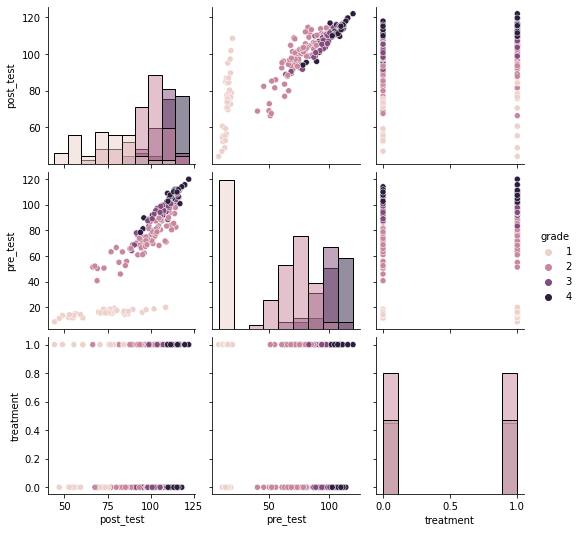

In [3]:
sns.pairplot(df.drop("pair_id", axis=1), hue="grade", diag_kind="hist")

In [4]:
# Prepare data for SLC models below.
treated_df = df[df["treatment"] == 1]
control_df = df[df["treatment"] == 0]

d_X = 5
n_instances = 2
n_objects = 96

# Process covariates with one-hot encoding of categorical "grade" covariate
X = np.ones((n_instances, n_objects, d_X))
X[0, :, 0]  = control_df["pre_test"].values
X[0, :, 1:] = pd.get_dummies(control_df["grade"]).values
X[1, :, 0]  = treated_df["pre_test"].values
X[1, :, 1:] = pd.get_dummies(treated_df["grade"]).values
X = torch.tensor(X).float()

T = np.ones((n_instances, n_objects))
T[0, :] = 0.
T = torch.tensor(T).float()

Y = np.ones((n_instances, n_objects))
Y[0, :] = control_df["post_test"].values
Y[1, :] = treated_df["post_test"].values
Y = torch.tensor(Y).float()

data = {"T":T, "X":X, "Y":Y}


## Model: SLC

Moving beyond
simple linear models, recent work has introduced *Gaussian Processes
with Structured Latent Confounders* (GP-SLC) [@witty2020], using
flexible Gaussian process priors for causal inference in hierarchical
settings. The following generative program is a slightly simplified
variant of GP-SLC.

In [5]:
class SLC(PyroModule):
    def __init__(self, 
                d_X = 5,
                d_U = 2,
                n_objects = 96, 
                n_instances = 2):
                
        super().__init__()
        self.d_X = d_X
        self.d_U = d_U
        self.n_objects = n_objects
        self.n_instances = n_instances

        self.outer_dim = -2

        self.treatment_shape = torch.Size([n_instances, n_objects])

    def f_X(self, U):
        raise NotImplementedError
    
    def f_T(self, U, X):
        raise NotImplementedError
    
    def f_Y(self, U, X, T):
        raise NotImplementedError

    def forward(self):
        # This structure implicitly assumes that each object has the same number of instances, and vice-versa. 
        # That's ok for this data, but would need to change for general SLC settings.

        with pyro.plate("objects", self.n_objects, dim=-1) as objects:
            U = pyro.sample("U", dist.Normal(0, 1).expand([self.d_U]).to_event(1))
            with pyro.plate("instances", self.n_instances, dim=-2) as instances:
                X = pyro.sample("X", dist.MultivariateNormal(*self.f_X(U)))
                p_T = torch.special.expit(self.f_T(U, X))
                T = pyro.sample("T", dist.Bernoulli(p_T))
                Y = pyro.sample("Y", dist.Normal(*self.f_Y(U, X, T)))
                return Y
        

In [6]:
class Linear(nn.Linear):
    # Custom version of Linear NN to avoid broadcasting error.
    def forward(self, input: Tensor) -> Tensor:
        return torch.einsum("...i,...ji->...j", input, self.weight) + self.bias


class LinearSLC(SLC):
    def __init__(self, include_prior=True, **kwargs):
        super().__init__(**kwargs)

        self.include_prior = include_prior

        self.X_mean_model = PyroModule[Linear](self.d_U, self.d_X)
        self.X_mean_model.weight = PyroSample(dist.Normal(0., 1.).expand([self.d_X, self.d_U]).to_event(2))
        self.X_mean_model.bias = PyroSample(dist.Normal(0., 1.).expand([self.d_X]).to_event(1))
        
        self.X_var = PyroSample(dist.HalfCauchy(1.).expand([self.d_X]).to_event(1))

        self.T_logit_model = PyroModule[Linear](self.d_X + self.d_U, 1)
        self.T_logit_model.weight = PyroSample(dist.Normal(0., 1.).expand([1, self.d_X + self.d_U]).to_event(2))
        self.T_logit_model.bias = PyroSample(dist.Normal(0., 1.).expand([1]).to_event(1))

        self.Y_mean_model = PyroModule[Linear](self.d_X + self.d_U, 2)
        self.Y_mean_model.weight = PyroSample(dist.Normal(0., 1.).expand([2, self.d_X + self.d_U]).to_event(2))
        self.Y_mean_model.bias = PyroSample(dist.Normal(0., 1.).expand([2]).to_event(1))

        self.Y_var = PyroSample(dist.HalfCauchy(1.).expand([1]).to_event(1))
        
    def param_prior(self):

        self.X_mean_model.weight
        self.X_mean_model.bias

        self.X_var

        self.T_logit_model.weight
        self.T_logit_model.bias

        self.Y_mean_model.weight
        self.Y_mean_model.bias
        
        self.Y_var

    def f_X(self, U):
        X_mean = self.X_mean_model(U)
        return X_mean, torch.diag_embed(self.X_var)

    def f_T(self, U, X):
        batch_shape = torch.broadcast_shapes(U.shape[:-1], X.shape[:-1])
        U = U.expand(batch_shape + U.shape[-1:])
        X = X.expand(batch_shape + X.shape[-1:])
        return self.T_logit_model(torch.concat((U, X), dim=-1)).squeeze(-1)

    def f_Y(self, U, X, T):
        batch_shape = torch.broadcast_shapes(U.shape[:-1], X.shape[:-1])
        U = U.expand(batch_shape + U.shape[-1:])
        X = X.expand(batch_shape + X.shape[-1:])
 
        Y_mean_ = self.Y_mean_model(torch.concat((U, X), dim=-1))  

        Y_mean = pyro.ops.indexing.Vindex(Y_mean_)[..., T.long()]

        return Y_mean, self.Y_var
        

    def forward(self):
        
        # Sample from priors over linear models.
        # If `self.include_prior = False` the prior density does not contribute to any log_density terms
        with pyro.poutine.mask(mask=self.include_prior):
            self.param_prior()

        # Run the parent model.
        return super().forward()

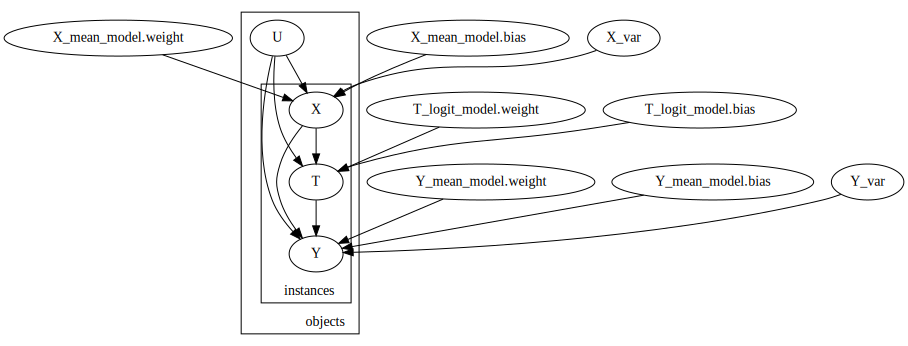

In [8]:
linear_slc = LinearSLC()
pyro.render_model(linear_slc)

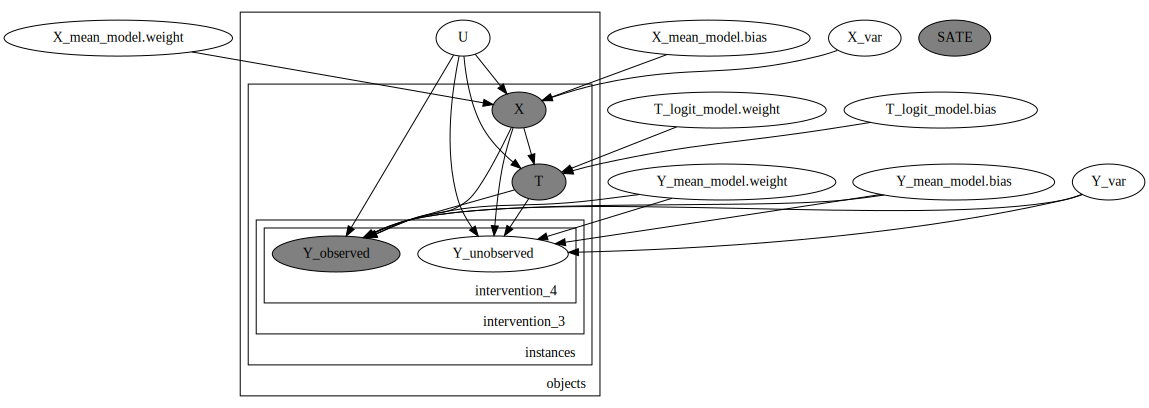

In [9]:
def SATE(model, treatment_name, data={}):

    def queried_model(*model_args, **kwargs):
        
        extended_model = do(actions={treatment_name: torch.zeros(model.treatment_shape)})(
                            do(actions={treatment_name: torch.ones(model.treatment_shape)})(
                                condition(data=data)(
                                    model)))

        with MultiWorldCounterfactual(dim=model.outer_dim-1):
            Y_cf = extended_model(*model_args, **kwargs)
        
        Y_treatment = Y_cf[..., 0, 1]
        Y_control = Y_cf[..., 1, 0]
        
        ITEs = Y_treatment - Y_control
        return pyro.deterministic("SATE", ITEs.mean(-1).mean(-1), event_dim=0)

    return queried_model

queried_linear_slc = SATE(linear_slc, "T", data=data)
pyro.render_model(queried_linear_slc)

## Setting up Inference and Optimization

In [10]:
# Optimization parameters used throughout
initial_lr = 0.03

def run_inference(model, guide, initial_lr, num_predictive_samples=1000, num_iterations=1000, verbose=False):
    adam = pyro.optim.Adam({'lr': initial_lr})
    elbo = pyro.infer.Trace_ELBO(num_particles=5, vectorize_particles=True)
    svi = SVI(model, guide, adam, loss=elbo)
    predictive = Predictive(model, guide=guide, num_samples=num_predictive_samples)

    for j in range(num_iterations):
        # calculate the loss and take a gradient step
        loss = svi.step()
        if verbose:
            if j % 100 == 0:
                print("[iteration %04d] loss: %.4f - SATE estimate: %.2f" % (j + 1, loss, predictive()['SATE'].mean()))
    
    return predictive()["SATE"]

## Running MAP Inference

In [14]:
pyro.clear_param_store()

map_model = SATE(LinearSLC(), "T", data=data)

map_guide = AutoDelta(map_model)

map_prediction = run_inference(map_model, map_guide, initial_lr=initial_lr, num_predictive_samples=1, verbose=True)

[iteration 0001] loss: 2798851.9303 - SATE estimate: 1.39
[iteration 0101] loss: 187005.8509 - SATE estimate: 1.37
[iteration 0201] loss: 55883.2986 - SATE estimate: 1.43
[iteration 0301] loss: 36897.6739 - SATE estimate: 1.47
[iteration 0401] loss: 31380.4479 - SATE estimate: 1.48
[iteration 0501] loss: 28270.8449 - SATE estimate: 1.49
[iteration 0601] loss: 27888.4082 - SATE estimate: 1.49
[iteration 0701] loss: 25595.6211 - SATE estimate: 1.50
[iteration 0801] loss: 24830.8547 - SATE estimate: 1.50
[iteration 0901] loss: 24255.9205 - SATE estimate: 1.50


## Running Mean Field SVI

In [15]:
pyro.clear_param_store()

mf_model = SATE(LinearSLC(), "T", data=data)

mf_guide = AutoNormal(mf_model)

mf_prediction = run_inference(mf_model, mf_guide, initial_lr=initial_lr, num_predictive_samples=100, verbose=True)

[iteration 0001] loss: 5745247.5126 - SATE estimate: 1.52
[iteration 0101] loss: 272625.8594 - SATE estimate: 1.57
[iteration 0201] loss: 106937.3941 - SATE estimate: 1.50
[iteration 0301] loss: 65302.4823 - SATE estimate: 1.74
[iteration 0401] loss: 46675.9530 - SATE estimate: 1.97
[iteration 0501] loss: 41432.0436 - SATE estimate: 1.34
[iteration 0601] loss: 34844.3676 - SATE estimate: 1.72
[iteration 0701] loss: 29823.0945 - SATE estimate: 1.56
[iteration 0801] loss: 28611.3205 - SATE estimate: 1.19
[iteration 0901] loss: 26144.5793 - SATE estimate: 1.68
